In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np
import os
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import h5py
import tables
from scipy import integrate
import pandas as pd
import random
from scipy.signal import find_peaks

In [3]:
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=16)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=16)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=16)    # legend fontsize
matplotlib.rc('figure', titlesize=16)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rc('figure.subplot', hspace=  0.4)
fs = 1/2e-9
def process_data(trace, recordlength):
    try:
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    except ValueError:
        trace = trace[:int(np.floor(len(trace)/recordlength))*recordlength,]
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    data= traceR-np.expand_dims(traceR[:,100:2000].mean(axis=1), axis=1)
#     print ('input trace length',trace.shape, 'processed trace shape',  data.shape)
    return data
def create_template(traces):
    template = np.mean(traces, axis = 0)
    template_norm= -template/min(template)
    return template,template_norm

def clippedwaveformsindex(data, clippingstart = -15100):
    clippedIdx = []
    data_max_idx = np.argmin(data, axis=1) 
    for i in range(len(data)):
        if data[i][data_max_idx[i]] < clippingstart:
            clippedIdx.append(i)
    return clippedIdx


def glitchesindex(data, threshold = 5):
    glitchesIdx = []
    
    std = ((data[:, 100:1000].std(axis=1)).reshape(len(data),1))
    t0idx = np.argmax(data<-(10*std), axis=1)   
        
    data_max_idx = np.argmin(data, axis=1)
    
    for i in range(len(data)):
        if data_max_idx[i] - t0idx[i] < threshold:
            glitchesIdx.append(i)
    return glitchesIdx


def pileupindex(data, ctype):
    pileupIdx, noisyIdx = [], []

    energy = np.sum(data/np.min(data, axis =1)[:, None], axis =1)
    
    if ctype == 'pure': distancefactor, prominencefactor = 15,  0.085
    else: distancefactor, prominencefactor = 200, 0.4
    if ctype == 'pure': threshold_min, threshold_max = 15,40
    else: threshold_min, threshold_max = 350,900
        
    data_max_idx = np.argmin(data, axis=1)
    data_max = data[np.arange(len(data_max_idx)),data_max_idx]  
    for i in range(0, len(data)):
        peaks, peak_properties = find_peaks(-data[i], prominence =(-data_max[i]*prominencefactor), distance=distancefactor)
        if len(peaks)>1 :
            pileupIdx.append(i)
        if energy[i] > threshold_max or energy[i] < threshold_min:
            noisyIdx.append(i)
    return pileupIdx, noisyIdx

def OF_calct0(signal, template_norm, psd_noise, fs, recordlength):
    amp, t0, chi2= [], [], []
    for trace in np.arange(len(signal)):
        OF = qp.OptimumFilter(signal[trace], template_norm, psd_noise, fs) # initialize the OptimumFilter class
        amp_withdelay, t0_withdelay, chi2_withdelay= OF.ofamp_withdelay() # t0_withdelay : time shift calculated for the pulse (in s).
        amp.append(amp_withdelay)
        t0.append(t0_withdelay)
        chi2.append(chi2_withdelay)
    return amp, t0, chi2


templateEM_Tl,  TemplateEM_Tl = create_template(np.load('templates/Tl_template_pulses.npy'))
templateHAD_Tl,  TemplateHAD_Tl = create_template(np.load('templates/Tl_template_pulses_neutron.npy'))

templateEM_p,  TemplateEM_p = create_template(np.load('templates/pure_template_pulses.npy'))
templateHAD_p,  TemplateHAD_p = create_template(np.load('templates/pure_template_pulses_neutron.npy'))

fs =1/2e-9

 
# energy in [ADC] / energyfactor = energy in [MeV]
'''energyfactor_pure 6243
energyfactor_Tl 118252

longtime_pure 250
shorttime_pure 24

longtime_Tl 11000
shorttime_Tl 600'''
def Ecalibration (amp, ctype):
    if ctype == 'Tl':
        return amp/118252
    if ctype == 'pure':
        return amp/6243

In [10]:

XFEL_Tl = h5py.File('saved_outputs/Tl_XFEL_beamON.hdf5')



_XFEL_Tl_amp = np.array(XFEL_Tl ['amp_withdelay_EM'][:])
_XFEL_Tl_t0pil = np.array(XFEL_Tl['t0_pileup_EM'][:])
_XFEL_Tl_amppil = np.array(XFEL_Tl['amp_pileup_EM'][:])
_XFEL_Tl_t0pil_ = np.array(XFEL_Tl['t0_pileup_Had'][:])
_XFEL_Tl_chi2pil = np.array(XFEL_Tl['chi2_pileup_EM'][:])
_XFEL_Tl_amppil_ = np.array(XFEL_Tl['amp_pileup_Had'][:])
_XFEL_Tl_deltachi2=np.array(XFEL_Tl ['Delta_chi2'])
_XFEL_Tl_chi2pil_ = np.array(XFEL_Tl['chi2_pileup_Had'][:]) 
select2 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]>0 and  abs(_XFEL_Tl_amppil[i] )>1000]
select4 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]>0 and  abs(_XFEL_Tl_t0pil[i]*fs )>2000]
selc = list (set(select2+select4))
sel = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]>0 and  abs(_XFEL_Tl_amppil[i] )>1000 or abs(_XFEL_Tl_t0pil[i]*fs )>2000]
sel2 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]>0 ]

In [11]:
print(len(sel))
print(len(selc))
print(len(select2), len(select4))
print(len(sel2))

1042761
993977
209524 845566
6028041


5611539
6522407
4900572


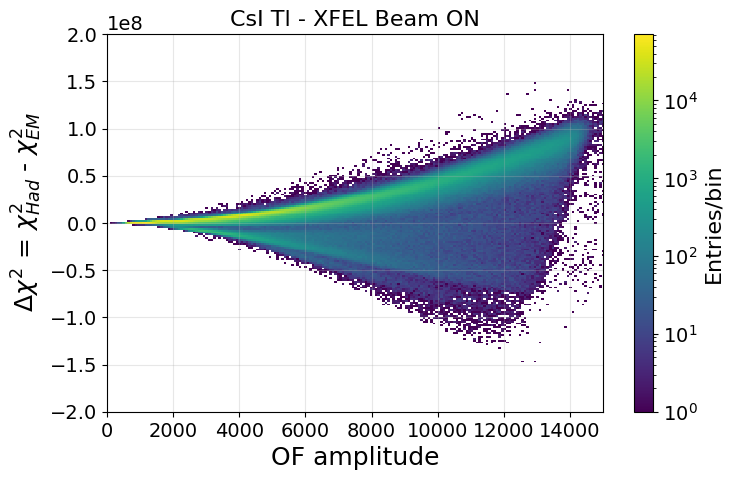

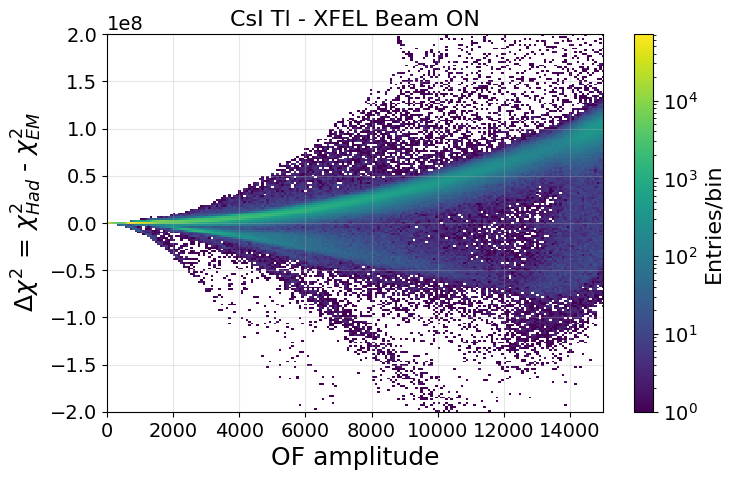

In [147]:

XFEL_Tl = h5py.File('saved_outputs/Tl_XFEL_beamON.hdf5')


gli= np.where(XFEL_Tl['glitch'][:]==True)[0]
clip= np.where(XFEL_Tl['clipped'][:]==True)[0]
pileup= np.where(XFEL_Tl['pileup'][:]==True)[0]
noisy= np.where(XFEL_Tl['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []


XFEL_Tl_amppil_hist = np.take(XFEL_Tl['amp_pileup_EM'][:], select)
XFEL_Tl_t0pil_hist = np.take(XFEL_Tl['t0_pileup_EM'][:], select)
XFEL_Tl_chi2pil_hist = np.take(XFEL_Tl['chi2_pileup_EM'][:], select)
XFEL_Tl_amppil_Had_hist = np.take(XFEL_Tl['amp_pileup_Had'][:], select)
XFEL_Tl_t0pil_Had_hist = np.take(XFEL_Tl['t0_pileup_Had'][:], select)
XFEL_Tl_chi2pil_Had_hist = np.take(XFEL_Tl['chi2_pileup_Had'][:], select)




XFEL_Tl_amp = np.delete(XFEL_Tl ['amp_withdelay_EM'][:],select)
XFEL_Tl_t0 = np.delete(XFEL_Tl ['t0_withdelay_EM'][:],select)
XFEL_Tl_amp_Had= np.delete(XFEL_Tl ['amp_withdelay_Had'][:],select)
XFEL_Tl_t0_Had= np.delete(XFEL_Tl ['t0_withdelay_Had'][:],select)
XFEL_Tl_deltachi2=np.delete(np.array(XFEL_Tl ['Delta_chi2']), select)
CR_Tl_XFEL = np.delete(np.array(XFEL_Tl ['charge_ratio']), select)
XFEL_Tl_rundata = np.delete(XFEL_Tl['rundata'][:],select)
XFEL_Tl_waveform_number = np.delete(XFEL_Tl['waveform_number'][:],select)
integrated_raw_amp_Tl_XFEL = np.delete(np.array(XFEL_Tl ['integrated_raw_amp']), select)
XFEL_Tl_amppil = np.delete(XFEL_Tl['amp_pileup_EM'][:], select)
XFEL_Tl_t0pil = np.delete(XFEL_Tl['t0_pileup_EM'][:], select)
XFEL_Tl_amppil_Had = np.delete(XFEL_Tl['amp_pileup_Had'][:], select)
XFEL_Tl_t0pil_Had = np.delete(XFEL_Tl['t0_pileup_Had'][:], select)
XFEL_Tl_chi2pil_Had = np.delete(XFEL_Tl['chi2_pileup_Had'][:], select)
print (len(XFEL_Tl_amp))

# plt.figure(figsize=(8, 5))
# plt.hist2d(XFEL_Tl_amp, XFEL_Tl_deltachi2,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid(alpha=0.3)
# plt.title('CsI Tl - XFEL Beam ON')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.show()


_XFEL_Tl_amp = np.array(XFEL_Tl ['amp_withdelay_EM'][:])
_XFEL_Tl_t0pil = np.array(XFEL_Tl['t0_pileup_EM'][:])
_XFEL_Tl_amppil = np.array(XFEL_Tl['amp_pileup_EM'][:])
_XFEL_Tl_t0pil_ = np.array(XFEL_Tl['t0_pileup_Had'][:])
_XFEL_Tl_chi2pil = np.array(XFEL_Tl['chi2_pileup_EM'][:])
_XFEL_Tl_amppil_ = np.array(XFEL_Tl['amp_pileup_Had'][:])
_XFEL_Tl_deltachi2=np.array(XFEL_Tl ['Delta_chi2'])
_XFEL_Tl_chi2pil_ = np.array(XFEL_Tl['chi2_pileup_Had'][:])

print(len(XFEL_Tl ['amp_withdelay_EM'][:]))


gli= np.where(XFEL_Tl['glitch'][:]==True)[0]
clip= np.where(XFEL_Tl['clipped'][:]==True)[0]
pileup= np.where(XFEL_Tl['pileup'][:]==True)[0]
noisy= np.where(XFEL_Tl['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []


select2 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]>0 and  abs(_XFEL_Tl_amppil[i] )>1000]
select3 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]<0 and abs(_XFEL_Tl_amppil_[i] )>1000]
select4 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]>0 and  abs(_XFEL_Tl_t0pil[i]*fs )>2000]
select5 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]<0 and abs(_XFEL_Tl_t0pil_[i]*fs )>2000]
select6 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]<0 and abs(_XFEL_Tl_amppil_[i] )>300 and (_XFEL_Tl_t0pil[i]*fs )<-50]
select7 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]<0 and abs(_XFEL_Tl_t0pil_[i]*fs )>300 and (_XFEL_Tl_t0pil_[i]*fs )<-50]
select = list(set(list(select)+ select3+select2+ select4+select5+ select6+select7))


XFEL_Tl_amp_1 = np.delete(XFEL_Tl ['amp_withdelay_EM'][:],select)

XFEL_Tl_t0_1 = np.delete(XFEL_Tl ['t0_withdelay_EM'][:],select)
integrated_raw_amp_Tl_XFEL_1 = np.delete(np.array(XFEL_Tl ['integrated_raw_amp']), select)
XFEL_Tl_rundata_1 = np.delete(XFEL_Tl['rundata'][:],select)
XFEL_Tl_t0_Had_1= np.delete(XFEL_Tl ['t0_withdelay_Had'][:],select)
XFEL_Tl_amp_Had_1= np.delete(XFEL_Tl ['amp_withdelay_Had'][:],select)
XFEL_Tl_waveform_number_1 = np.delete(XFEL_Tl['waveform_number'][:],select)
XFEL_Tl_deltachi2_1=np.delete(np.array(XFEL_Tl ['Delta_chi2']), select)
CR_Tl_XFEL_1 = np.delete(np.array(XFEL_Tl ['charge_ratio']), select)
XFEL_Tl_amppil_1 = np.delete(XFEL_Tl['amp_pileup_EM'][:], select)
XFEL_Tl_t0pil_1 = np.delete(XFEL_Tl['t0_pileup_EM'][:], select)
XFEL_Tl_amppil_Had_1 = np.delete(XFEL_Tl['amp_pileup_Had'][:], select)
XFEL_Tl_t0pil_Had_1 = np.delete(XFEL_Tl['t0_pileup_Had'][:], select)
XFEL_Tl_chi2pil_Had_1 = np.delete(XFEL_Tl['chi2_pileup_Had'][:],select)

print (len(XFEL_Tl_amp_1))
XFEL_Tl_t0_2 = np.take(XFEL_Tl ['t0_withdelay_EM'][:],select)
XFEL_Tl_amp_2 = np.take(XFEL_Tl ['amp_withdelay_EM'][:],select)
XFEL_Tl_deltachi2_2=np.take(np.array(XFEL_Tl ['Delta_chi2']), select)
XFEL_Tl_rundata_2 = np.take(XFEL_Tl['rundata'][:],select)
XFEL_Tl_waveform_number_2 = np.take(XFEL_Tl['waveform_number'][:],select)
XFEL_Tl_t0_Had_2= np.take(XFEL_Tl ['t0_withdelay_Had'][:],select)
XFEL_Tl_amp_Had_2= np.take(XFEL_Tl ['amp_withdelay_Had'][:],select)
XFEL_Tl_amppil_2 = np.take(XFEL_Tl['amp_pileup_EM'][:],select)
XFEL_Tl_t0pil_2 = np.take(XFEL_Tl['t0_pileup_EM'][:],select)
XFEL_Tl_amppil_Had_2 = np.take(XFEL_Tl['amp_pileup_Had'][:],select)
XFEL_Tl_t0pil_Had_2 = np.take(XFEL_Tl['t0_pileup_Had'][:],select)
XFEL_Tl_chi2pil_Had_2 = np.take(XFEL_Tl['chi2_pileup_Had'][:],select)


plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_Tl_amp_1, XFEL_Tl_deltachi2_1,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.show()

plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_Tl_amp_2, XFEL_Tl_deltachi2_2,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.show()


In [148]:
print(len(select6), len(select7))

37380 58164


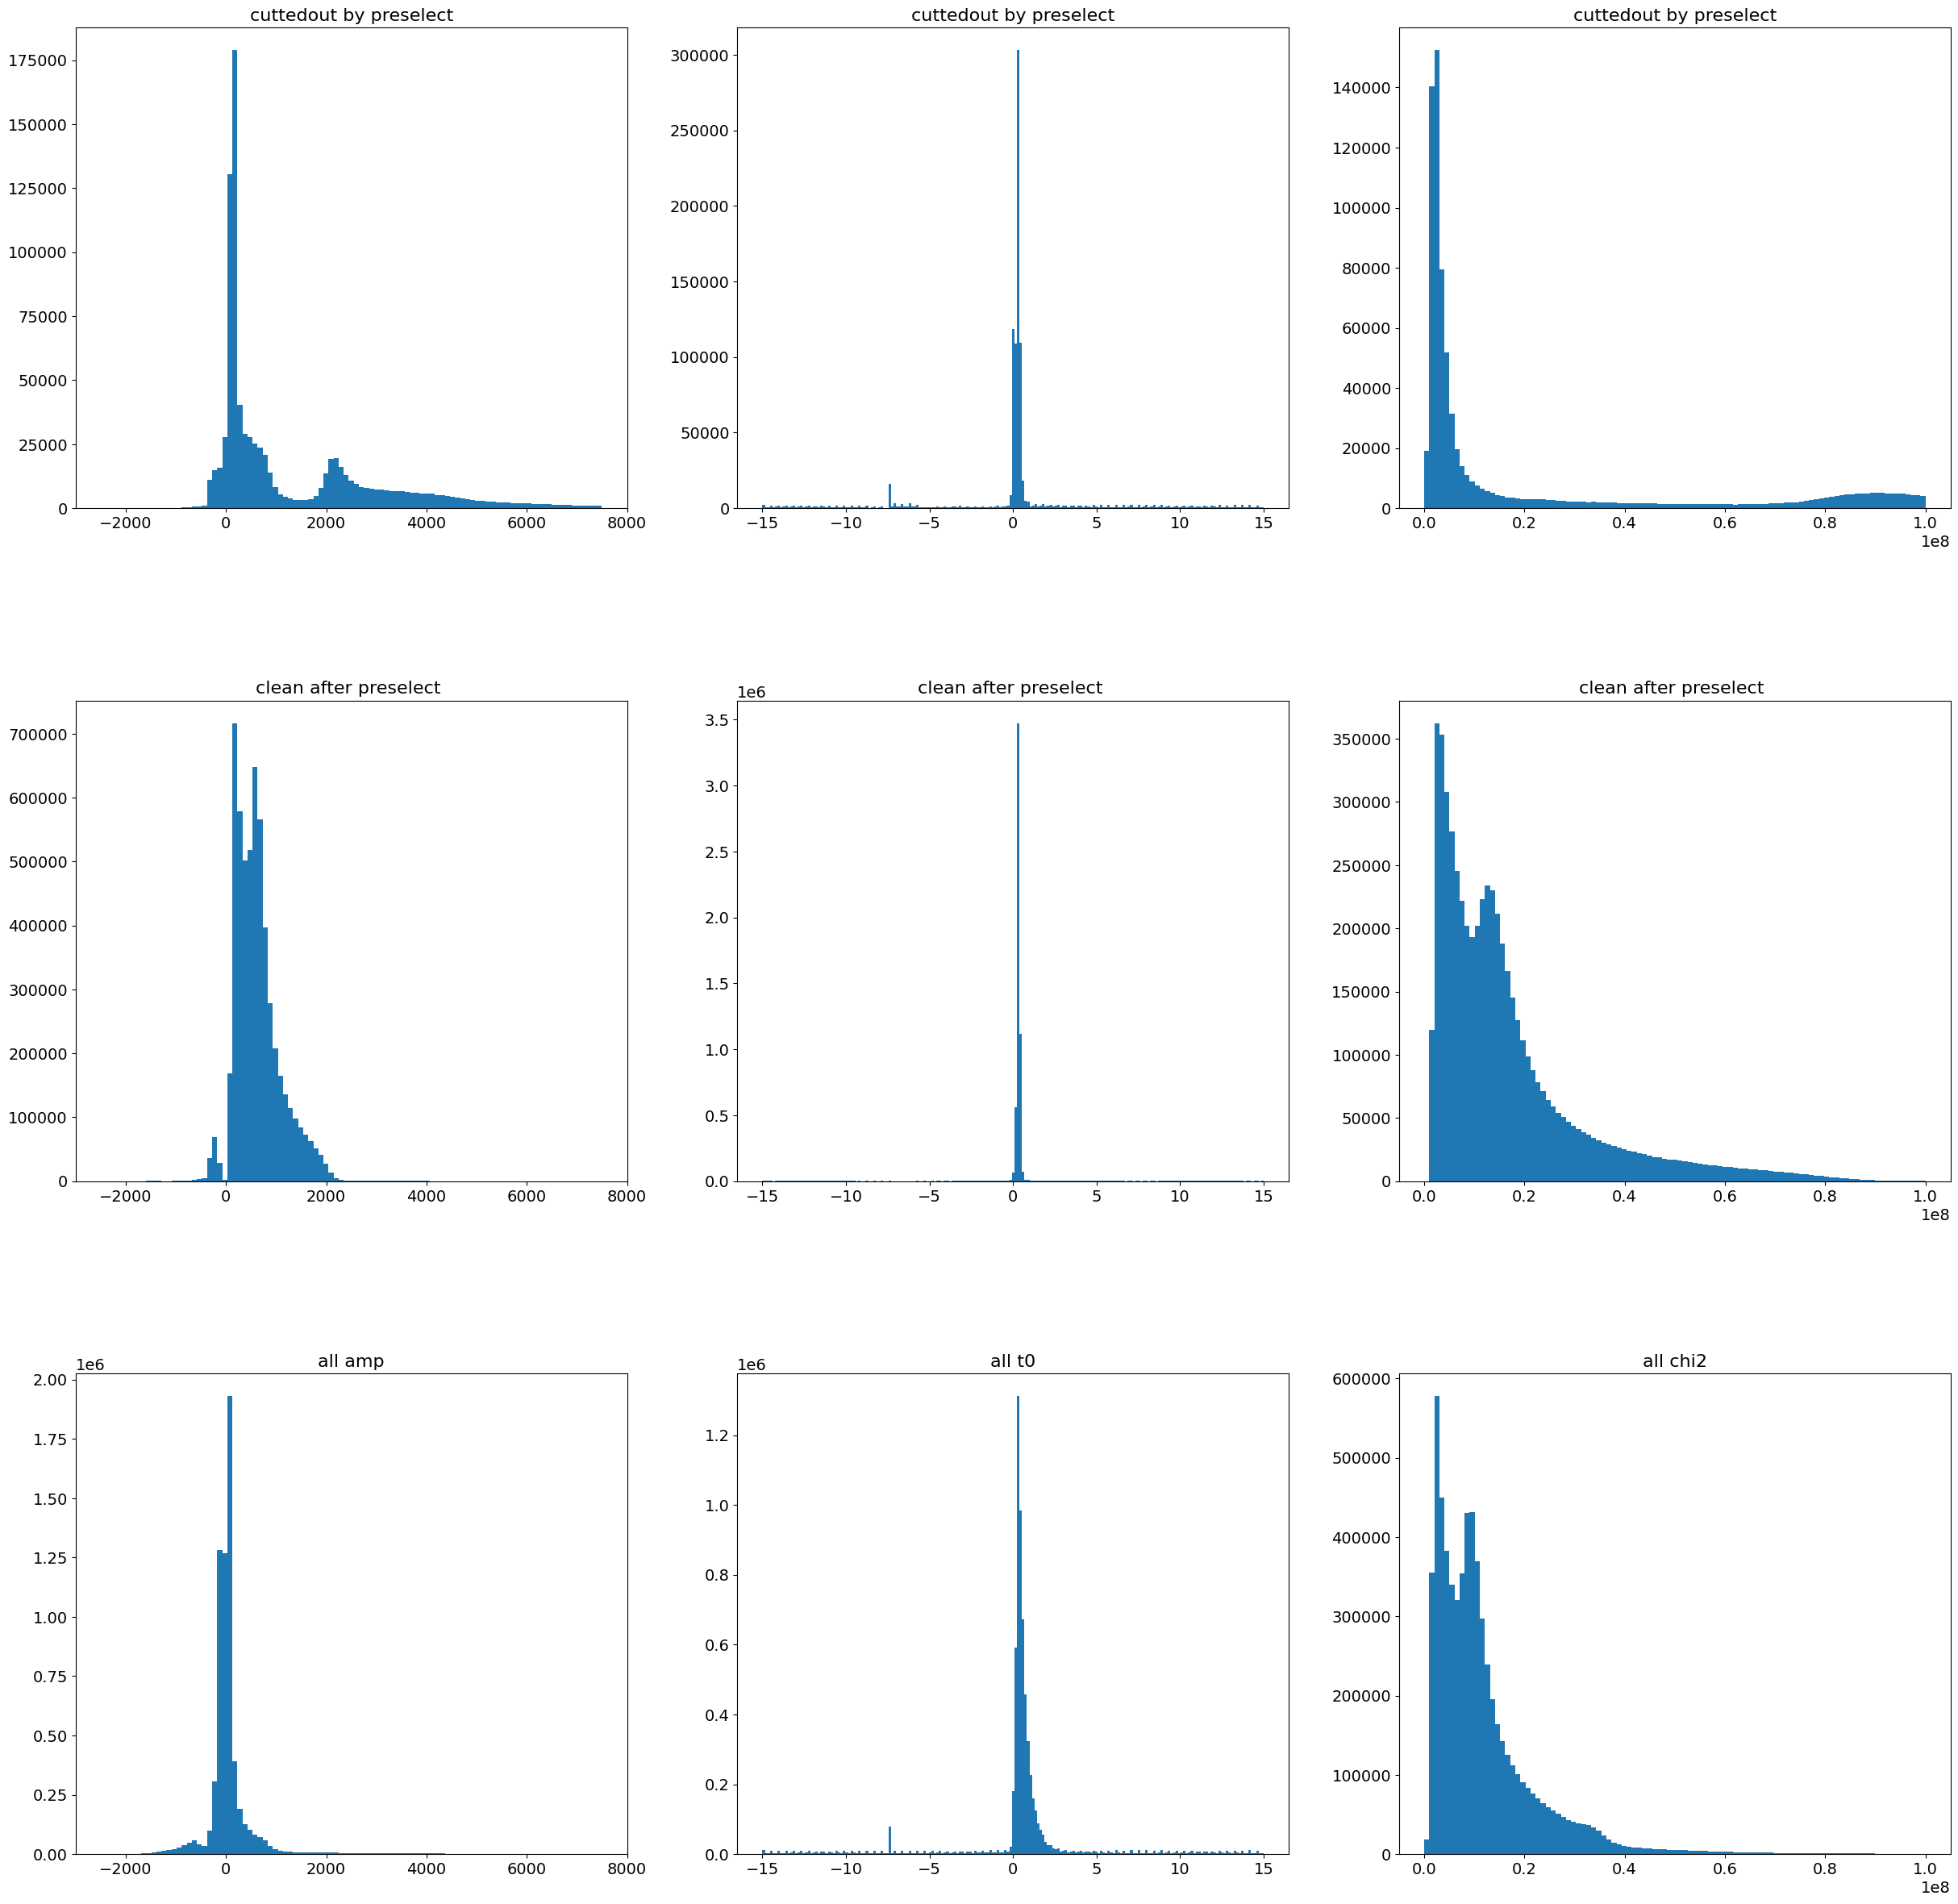

In [164]:
plt.figure(figsize = (30,30))
plt.subplot(3,3,1)
plt.hist(XFEL_Tl_amppil_Had_hist , bins = np.linspace(-2500,7500,100))
plt.title('cuttedout by preselect')
plt.subplot(3,3,2)
plt.hist(XFEL_Tl_t0pil_Had_hist*fs*2e-3 , bins = np.linspace(-15,15,200))
plt.title('cuttedout by preselect')
plt.subplot(3,3,3)
plt.hist(XFEL_Tl_chi2pil_Had_hist , bins = np.linspace(0,0.1e9,100))
plt.title('cuttedout by preselect')
plt.subplot(3,3,4)
plt.hist(XFEL_Tl_amppil_Had , bins = np.linspace(-2500,7500,100))
plt.title('clean after preselect ')
plt.subplot(3,3,5)
plt.hist(XFEL_Tl_t0pil_Had*fs*2e-3 , bins = np.linspace(-15,15,200))
plt.title('clean after preselect ')
plt.subplot(3,3,6)
plt.hist(XFEL_Tl_chi2pil_Had, bins = np.linspace(0,0.1e9,100))
plt.title('clean after preselect ')
plt.subplot(3,3,7)
plt.hist(XFEL_Tl['amp_pileup_EM'][:] , bins = np.linspace(-2500,7500,100))
plt.title('all amp')
plt.subplot(3,3,8)
plt.hist(XFEL_Tl['t0_pileup_EM'][:]*fs*2e-3 , bins = np.linspace(-15,15,200))
plt.title('all t0')
plt.subplot(3,3,9)
plt.hist(XFEL_Tl['chi2_pileup_EM'][:] , bins = np.linspace(0,0.1e9,100))
plt.title('all chi2')
plt.show()

In [ ]:
# print(len(XFEL_Tl['t0_pileup_EM'][:]), len(XFEL_Tl_t0pil), len(XFEL_Tl_t0pil_1))
# plt.hist(XFEL_Tl['t0_pileup_EM'][:]*fs*2e-3, bins =50)
# plt.yscale('log')
# plt.title('CsI Tl - Beam ON - before pre-selection')
# plt.xlabel('Pileup t0 [ms]')
# plt.ylabel('a.u.')
# plt.show()
# plt.hist(XFEL_Tl_t0pil*fs*2e-3, bins =50)
# plt.yscale('log')
# plt.title('CsI Tl - Beam ON - after pre-selection')
# plt.xlabel('Pileup t0 [ms]')
# plt.ylabel('a.u.')
# plt.show()
# plt.hist(XFEL_Tl_t0pil_1*fs*2e-3, bins =50)
# plt.yscale('log')
# plt.title('CsI Tl - Beam ON - after fine-tuning')
# plt.xlabel('Pileup t0 [ms]')
# plt.ylabel('a.u.')
# plt.show()

In [151]:

# l , m = [], []
# for n in range (len (XFEL_Tl_amp_2)):
#     if XFEL_Tl_amp_2[n]>6000 and XFEL_Tl_amp_2[n]<6100:
#         l.append(n)
        
# for i in l:        
#     if XFEL_Tl_deltachi2_2[i]>-0.5e8 and XFEL_Tl_deltachi2_2[i]<-0.2e8:
#         m.append(i)
# print(len(l), len(m))


l , m = [], []
for n in range (len (XFEL_Tl_amp_1)):
    if XFEL_Tl_amp_1[n]>12700 and XFEL_Tl_amp_1[n]<12800:
        l.append(n)
        
for i in l:        
    if XFEL_Tl_deltachi2_1[i]>-0.3e8 and XFEL_Tl_deltachi2_1[i]<-0.1e8:
        m.append(i)
print(len(l), len(m))


# XFEL_Tl_amppil = np.array(XFEL_Tl['amp_pileup_EM'][:])
# XFEL_Tl_t0pil = np.array(XFEL_Tl['t0_pileup_EM'][:])
# XFEL_Tl_amppil_Had = np.array(XFEL_Tl['amp_pileup_Had'][:])
# XFEL_Tl_t0pil_Had = np.array(XFEL_Tl['t0_pileup_Had'][:])

6922 86


150.0 830.8045193030985 0.30156792364956064
[517.07733298]
[517.07976044]
(1, 15000)


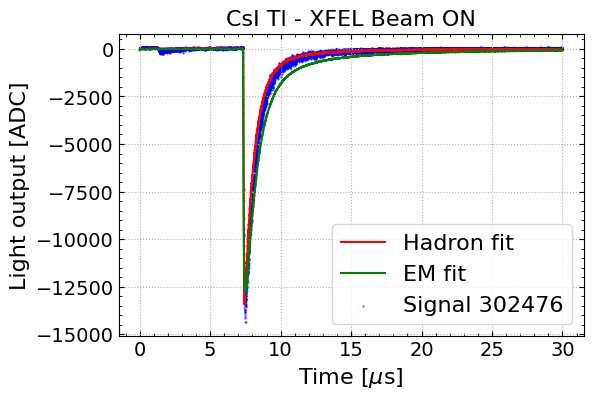

110.0 643.005184060481 0.2605974181192991
[577.65488886]
[577.6521356]
(1, 15000)


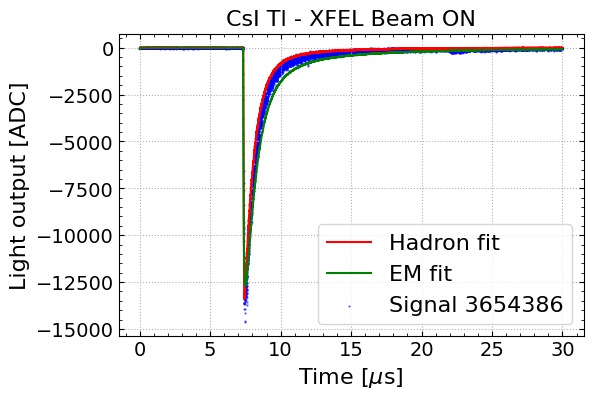

172.0 805.1841556938898 0.34262152279217273
[620.12895531]
[620.12597309]
(1, 15000)


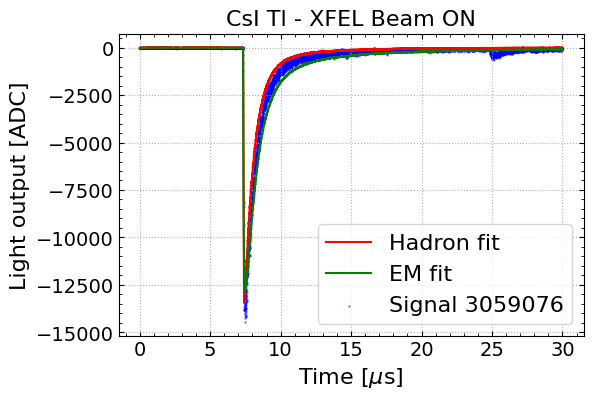

249.0 810.9569860613751 0.3198161652655517
[556.87002605]
[556.86860694]
(1, 15000)


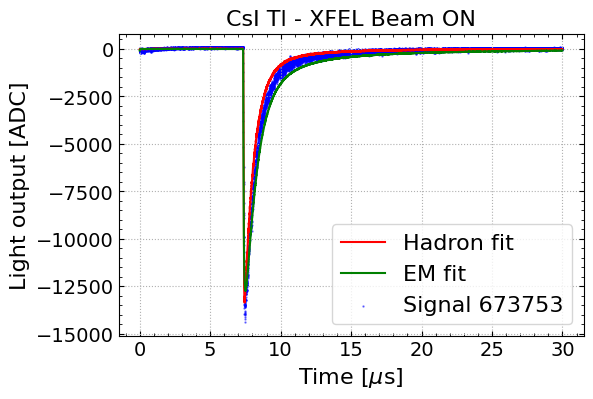

206.0 629.5885947916058 0.2977484120879736
[656.39876238]
[656.38914203]
(1, 15000)


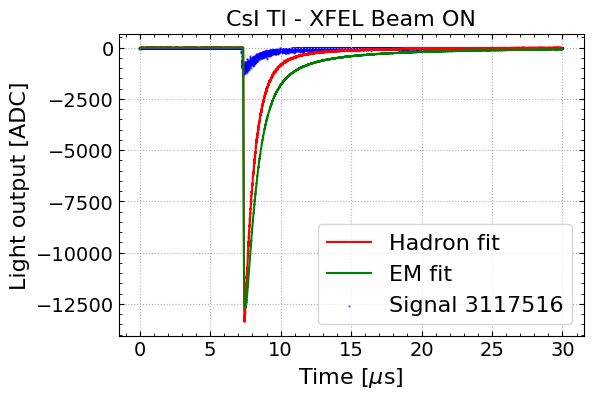

131.0 837.5804376152473 0.29442091631328626
[649.74210839]
[649.73926698]
(1, 15000)


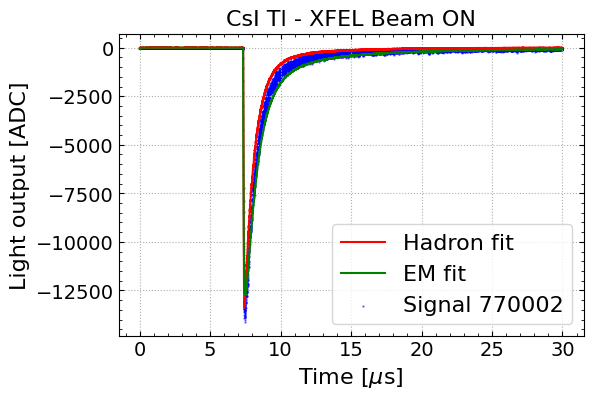

219.0 787.1408738944006 0.31564450264921234
[624.10618658]
[624.10608153]
(1, 15000)


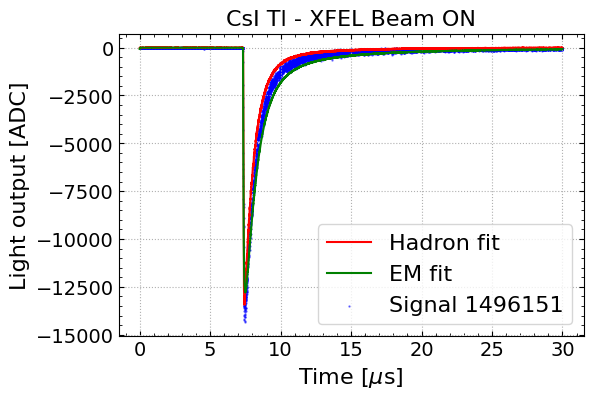

187.0 739.0721096918428 0.28809347617713
[619.08367092]
[619.08186366]
(1, 15000)


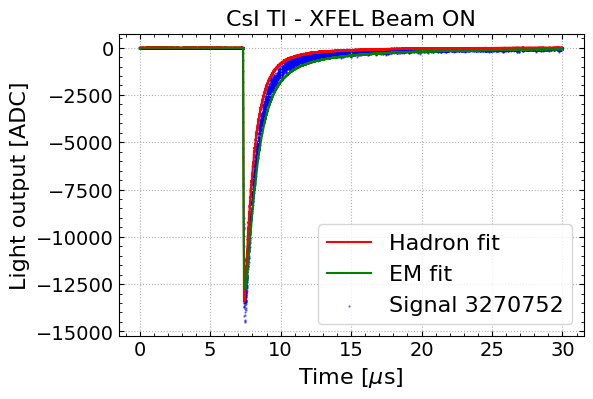

217.0 662.653442830052 0.2808615249390207
[602.15308596]
[602.15235167]
(1, 15000)


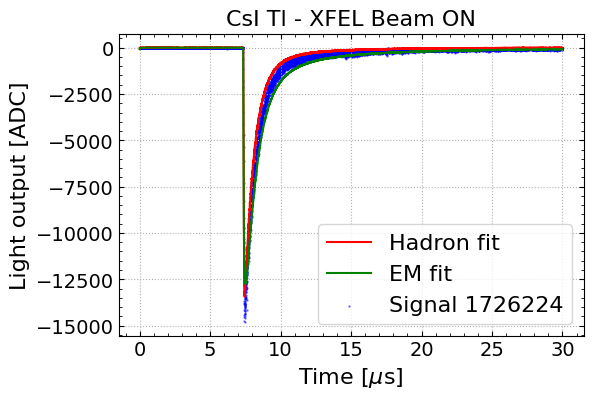

110.0 729.2369541505041 0.3053011312786284
[604.43775119]
[604.43733896]
(1, 15000)


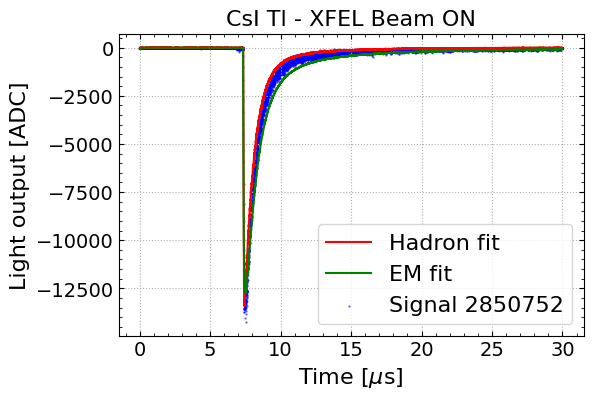

CPU times: user 23.9 s, sys: 2.33 s, total: 26.2 s
Wall time: 57.1 s


In [152]:
%%time
m = random.sample(m, 10)
for n in range(len(m)):    
    wavenum = XFEL_Tl_waveform_number_1[m][n]-1
#     print(wavenum, m[n])
    print(XFEL_Tl_t0pil_Had_1[m][n]*fs, XFEL_Tl_amppil_Had_1[m][n], XFEL_Tl_chi2pil_Had_1[m][n]/1e8)
    
    if XFEL_Tl_rundata_1[m][n].decode('utf-8')[12:17] == 'XFEL0': 
        infolder ='../../../../../../../../media/s/SeagateHD/'+XFEL_Tl_rundata_1[m][n].decode('utf-8')[12:18]+'/'
        chunks = pd.read_csv(infolder+XFEL_Tl_rundata_1[m][n].decode('utf-8')+'.txt', skiprows=wavenum*15000, chunksize = 15000,  header = None)
    else: 
        infolder ='../../../../../../../../media/s/SeagateHD/'+XFEL_Tl_rundata_1[m][n].decode('utf-8')[12:23]+'/'
        chunks = pd.read_csv(infolder+XFEL_Tl_rundata_1[m][n].decode('utf-8')+'.txt', skiprows=wavenum*15000, chunksize = 15000,  header = None)

    trace_3 = chunks.get_chunk(15000).values.reshape( 15000, 1)
    trace_3 = trace_3.T-np.expand_dims(trace_3[100:1000,:].mean(axis=0), axis=0).T
    print (np.sum(trace_3/np.min(trace_3, axis =1), axis =1))
    print (integrate.trapz(y = trace_3, dx = 1)/np.min(trace_3, axis =1))
    print(trace_3.shape)
    plt.scatter(np.arange(15000)*2e-3, trace_3[0], label='Signal %s'%m[n], color='blue', marker = '.' , alpha=0.5, s =2)
    plt.plot(np.arange(15000)*2e-3, XFEL_Tl_amp_Had_1[m][n]*np.roll(TemplateHAD_Tl, round(XFEL_Tl_t0_Had_1[m][n]*(1/2e-9))), 
            label='Hadron fit ', color='red',linewidth ='1.5')#, linestyle='dotted')
    plt.plot(np.arange(15000)*2e-3, XFEL_Tl_amp_1[m][n]*np.roll(TemplateEM_Tl, round(XFEL_Tl_t0_1[m][n]*(1/2e-9))), 
            label='EM fit ', color='green',linewidth ='1.5')#, linestyle='dotted')
#     plt.xlim(7.3,7.8)
    plt.ylabel(r'Light output [ADC]',fontsize = 16)
    plt.xlabel(r'Time [$\mu$s]',fontsize = 16)
    plt.title('CsI Tl - XFEL Beam ON',fontsize = 16)
    plt.tick_params(which='both', direction='in', right=True, top=True)
    plt.legend(loc = 'lower right', fontsize =16)
    #     plt.xlim(7.2,7.6)
    plt.grid(linestyle='dotted')
    plt.minorticks_on()
    plt.show()
#     if n ==0: template_array = trace_3
#     else: template_array = np.append(template_array,trace_3, axis=0)
    


-5010501.666666658
[537.31818921]
[537.3184554]


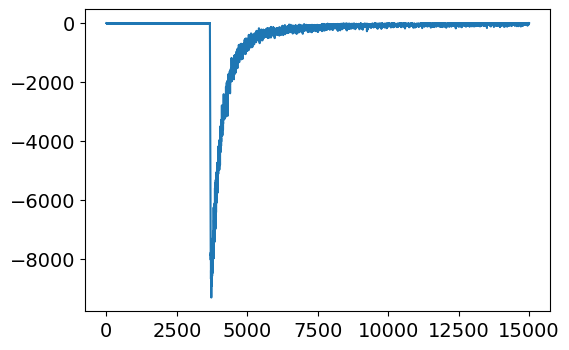

In [41]:
plt.plot(range(15000), trace_3[0])
print(np.sum(trace_3))
print (np.sum(trace_3/np.min(trace_3, axis =1), axis =1))
print (integrate.trapz(y = trace_3, dx = 1)/np.min(trace_3, axis =1))

7163151
5384155
3794219


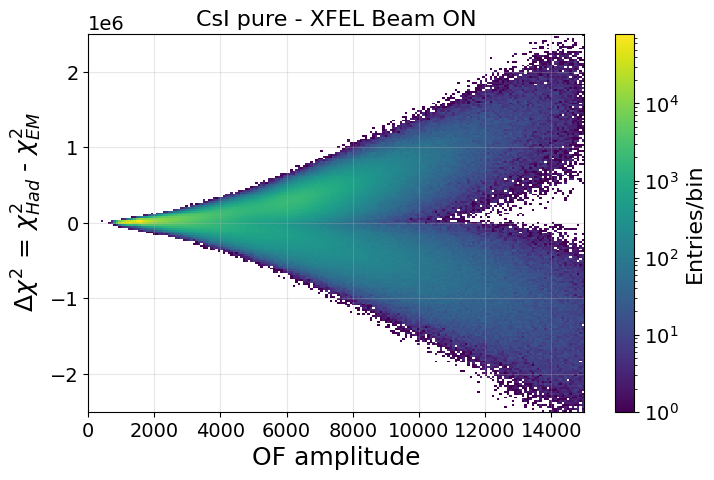

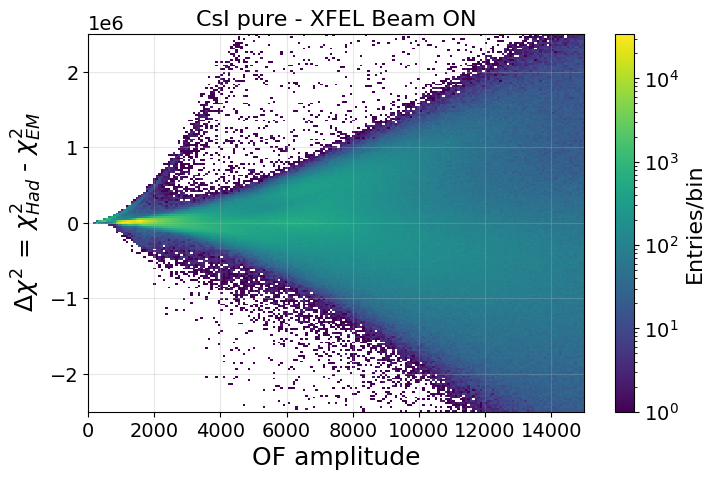

In [159]:

XFEL_p = h5py.File('saved_outputs/pure_XFEL_beamON.hdf5')

print(len(XFEL_p ['amp_withdelay_EM'][:]))
gli= np.where(XFEL_p['glitch'][:]==True)[0]
clip= np.where(XFEL_p['clipped'][:]==True)[0]
pileup= np.where(XFEL_p['pileup'][:]==True)[0]
noisy= np.where(XFEL_p['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []

XFEL_p_amppil_Had_hist= np.take(XFEL_p ['amp_pileup_Had'], select)
XFEL_p_t0pil_Had_hist= np.take(XFEL_p ['t0_pileup_Had'], select)
XFEL_p_chi2pil_Had_hist= np.take(XFEL_p ['chi2_pileup_Had'], select)


XFEL_p_amppil_Had= np.delete(XFEL_p ['amp_pileup_Had'], select)
XFEL_p_t0pil_Had= np.delete(XFEL_p ['t0_pileup_Had'], select)
XFEL_p_chi2pil_Had= np.delete(XFEL_p ['chi2_pileup_Had'], select)

XFEL_p_amp = np.delete(XFEL_p ['amp_withdelay_EM'][:],select)
XFEL_p_deltachi2=np.delete(np.array(XFEL_p ['Delta_chi2']), select)
integrated_raw_amp_p_XFEL = np.delete(np.array(XFEL_p ['integrated_raw_amp']), select)
CR_p_XFEL = np.delete(np.array(XFEL_p ['charge_ratio']), select)

print (len(XFEL_p_amp))


# plt.figure(figsize=(8, 5))
# plt.hist2d(XFEL_p_amp, XFEL_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)), cmin=1, norm=LogNorm())
# plt.xlabel(r'OF amplitude',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.xlim(0,15000)
# plt.grid(alpha=0.3)
# plt.title('CsI pure - XFEL Beam ON')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# plt.show()



XFEL_p_amp = np.array(XFEL_p ['amp_withdelay_EM'][:])
XFEL_p_t0pil = np.array(XFEL_p['t0_pileup_EM'][:])
XFEL_p_amppil = np.array(XFEL_p['amp_pileup_EM'][:])
XFEL_p_t0pil_ = np.array(XFEL_p['t0_pileup_Had'][:])
XFEL_p_amppil_ = np.array(XFEL_p['amp_pileup_Had'][:])
XFEL_p_deltachi2=np.array(XFEL_p ['Delta_chi2'])



gli= np.where(XFEL_p['glitch'][:]==True)[0]
clip= np.where(XFEL_p['clipped'][:]==True)[0]
pileup= np.where(XFEL_p['pileup'][:]==True)[0]
noisy= np.where(XFEL_p['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []

# select3 = [i for i in range (len(XFEL_p_amp)) if abs(XFEL_p_t0pil[i]*fs) > 350 and abs(XFEL_p_amppil[i] )>400 or abs(XFEL_p_amppil[i] )>1000]

select2 = [i for i in range (len(XFEL_p_amp)) if XFEL_p_deltachi2[i]>0 and  abs(XFEL_p_amppil[i] )>200]
select3 = [i for i in range (len(XFEL_p_amp)) if XFEL_p_deltachi2[i]<0 and abs(XFEL_p_amppil_[i] )>200]
select4 = [i for i in range (len(XFEL_p_amp)) if XFEL_p_deltachi2[i]>0 and  abs(XFEL_p_t0pil[i]*fs )>200]
select5 = [i for i in range (len(XFEL_p_amp)) if XFEL_p_deltachi2[i]<0 and abs(XFEL_p_t0pil_[i]*fs )>200]
select = list(set(list(select)+ select3+select2+select4 + select5))

XFEL_p_amp_1 = np.delete(XFEL_p ['amp_withdelay_EM'][:],select)
XFEL_p_deltachi2_1=np.delete(np.array(XFEL_p ['Delta_chi2']), select)
integrated_raw_amp_p_XFEL_1 = np.delete(np.array(XFEL_p ['integrated_raw_amp']), select)
CR_p_XFEL_1 = np.delete(np.array(XFEL_p ['charge_ratio']), select)
XFEL_p_t0pil_1 = np.delete(XFEL_p['t0_pileup_EM'][:],select)
XFEL_p_rundata_1 = np.delete(XFEL_p['rundata'][:],select)
XFEL_p_waveform_number_1 = np.delete(XFEL_p['waveform_number'][:],select)
XFEL_p_t0_Had_1= np.delete(XFEL_p ['t0_withdelay_Had'][:],select)
XFEL_p_amp_Had_1= np.delete(XFEL_p ['amp_withdelay_Had'][:],select)
XFEL_p_amppil_1 = np.delete(XFEL_p['amp_pileup_EM'][:],select)
XFEL_p_t0pil_1 = np.delete(XFEL_p['t0_pileup_EM'][:],select)
XFEL_p_amppil_Had_1 = np.delete(XFEL_p['amp_pileup_Had'][:],select)
XFEL_p_t0pil_Had_1 = np.delete(XFEL_p['t0_pileup_Had'][:],select)
XFEL_p_chi2pil_Had_1 = np.delete(XFEL_p['chi2_pileup_Had'][:],select)
print (len(XFEL_p_amp_1))

XFEL_p_t0_2 = np.take(XFEL_p ['t0_withdelay_EM'][:],select)
XFEL_p_amp_2 = np.take(XFEL_p ['amp_withdelay_EM'][:],select)
XFEL_p_deltachi2_2=np.take(np.array(XFEL_p ['Delta_chi2']), select)
XFEL_p_rundata_2 = np.take(XFEL_p['rundata'][:],select)
XFEL_p_waveform_number_2 = np.take(XFEL_p['waveform_number'][:],select)
XFEL_p_t0_Had_2= np.take(XFEL_p ['t0_withdelay_Had'][:],select)
XFEL_p_amp_Had_2= np.take(XFEL_p ['amp_withdelay_Had'][:],select)
XFEL_p_amppil_2 = np.take(XFEL_p['amp_pileup_EM'][:],select)
XFEL_p_t0pil_2 = np.take(XFEL_p['t0_pileup_EM'][:],select)
XFEL_p_amppil_Had_2 = np.take(XFEL_p['amp_pileup_Had'][:],select)
XFEL_p_t0pil_Had_2 = np.take(XFEL_p['t0_pileup_Had'][:],select)
XFEL_p_chi2pil_Had_2 = np.take(XFEL_p['chi2_pileup_Had'][:],select)



plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_p_amp_1, XFEL_p_deltachi2_1,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.show()



plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_p_amp_2, XFEL_p_deltachi2_2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.show()





In [113]:
print(len(select5) ,len(select4))

705403 641668


In [110]:
print(len( [i for i in range (len(XFEL_p_amp_1)) if XFEL_p_amp_1[i] <-15000 ]))


0


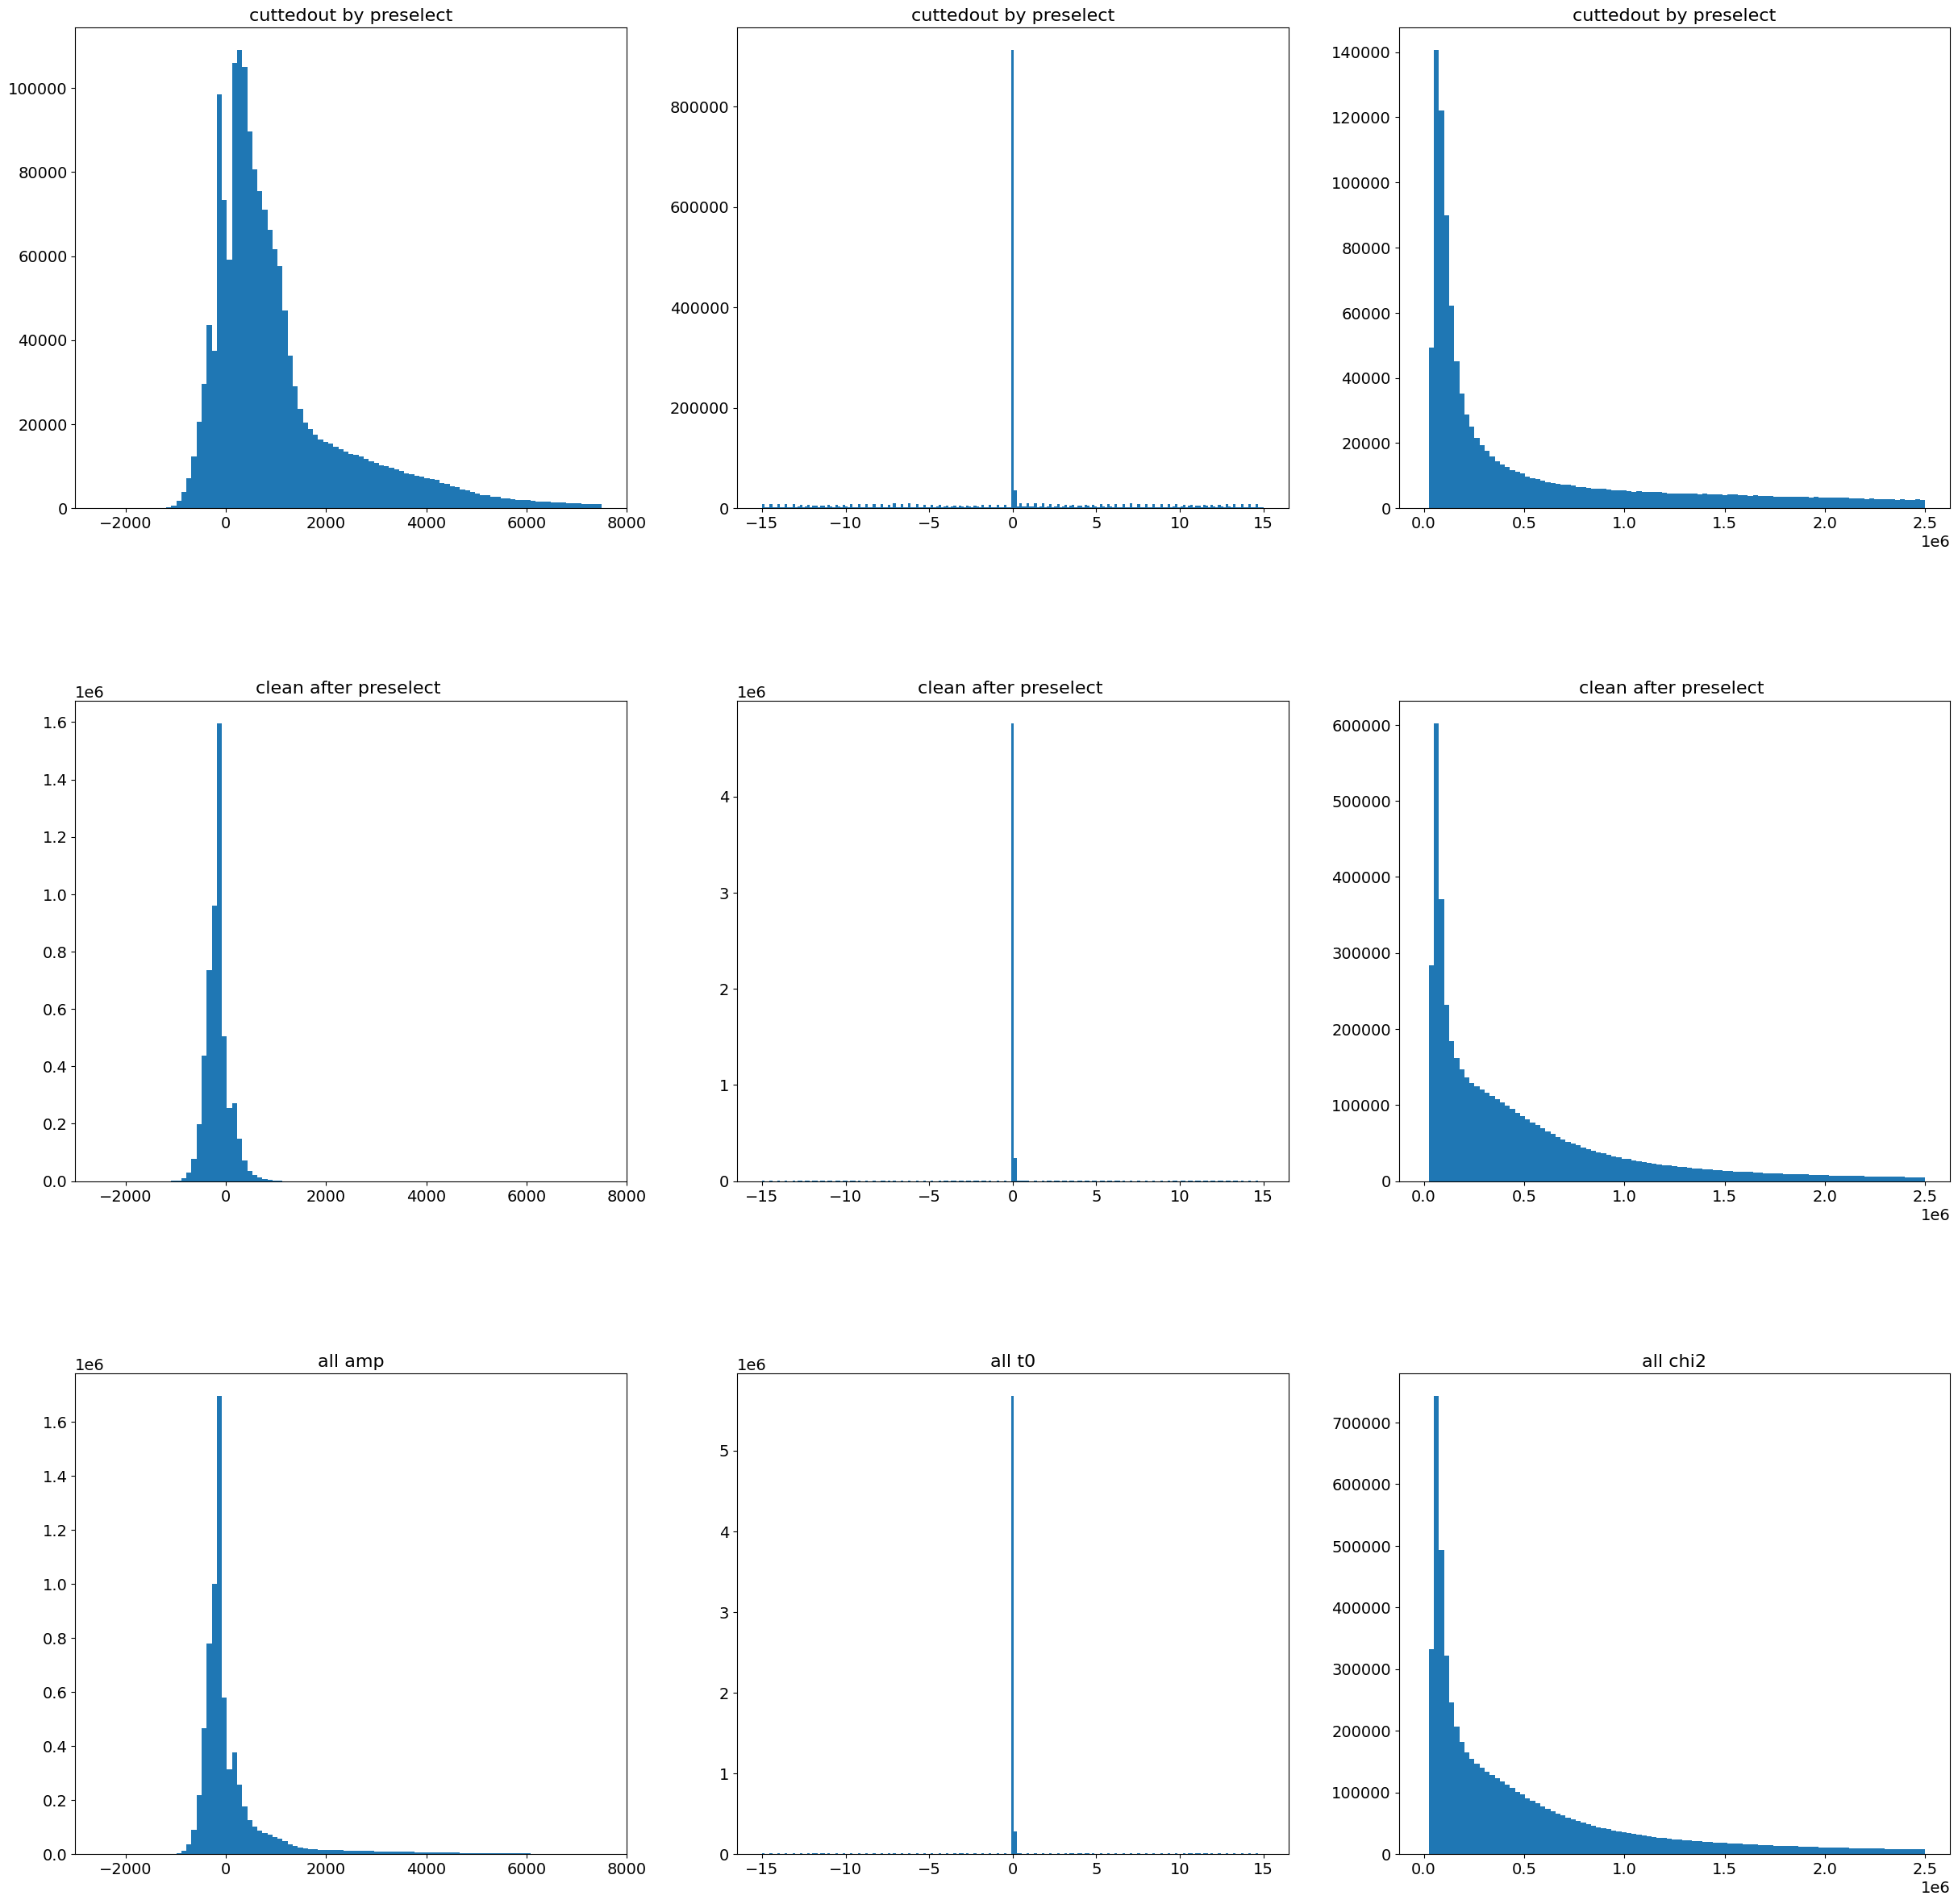

In [161]:
plt.figure(figsize = (30,30))
plt.subplot(3,3,1)
plt.hist(XFEL_p_amppil_Had_hist , bins = np.linspace(-2500,7500,100))
plt.title('cuttedout by preselect')
plt.subplot(3,3,2)
plt.hist(XFEL_p_t0pil_Had_hist*fs*2e-3 , bins = np.linspace(-15,15,200))
plt.title('cuttedout by preselect')
plt.subplot(3,3,3)
plt.hist(XFEL_p_chi2pil_Had_hist , bins = np.linspace(0,0.25e7,100))
plt.title('cuttedout by preselect')
plt.subplot(3,3,4)
plt.hist(XFEL_p_amppil_Had , bins = np.linspace(-2500,7500,100))
plt.title('clean after preselect ')
plt.subplot(3,3,5)
plt.hist(XFEL_p_t0pil_Had*fs*2e-3 , bins = np.linspace(-15,15,200))
plt.title('clean after preselect ')
plt.subplot(3,3,6)
plt.hist(XFEL_p_chi2pil_Had, bins = np.linspace(0,0.25e7,100))
plt.title('clean after preselect ')
plt.subplot(3,3,7)
plt.hist(XFEL_p['amp_pileup_Had'][:] , bins = np.linspace(-2500,7500,100))
plt.title('all amp')
plt.subplot(3,3,8)
plt.hist(XFEL_p['t0_pileup_Had'][:]*fs*2e-3 , bins = np.linspace(-15,15,200))
plt.title('all t0')
plt.subplot(3,3,9)
plt.hist(XFEL_p['chi2_pileup_Had'][:] , bins = np.linspace(0,0.25e7,100))
plt.title('all chi2')
plt.show()

In [157]:

# l , m = [], []
# for n in range (len (XFEL_p_amp_2)):
#     if XFEL_p_amp_2[n]>6000 and XFEL_p_amp_2[n]<6100:
#         l.append(n)
        
# for i in l:        
#     if XFEL_p_deltachi2_2[i]>-0.5e6 and XFEL_p_deltachi2_2[i]<-0.1e6:
#         m.append(i)
# print(len(l), len(m))


l , m = [], []
for n in range (len (XFEL_p_amp_1)):
    if XFEL_p_amp_1[n]>12700 and XFEL_p_amp_1[n]<12800:
        l.append(n)
        
for i in l:        
    if XFEL_p_deltachi2_1[i]>-0.2e6 and XFEL_p_deltachi2_1[i]<-0.1e6:
        m.append(i)
print(len(l), len(m))

# XFEL_p_amppil = np.array(XFEL_p['amp_pileup_EM'][:])
# XFEL_p_t0pil = np.array(XFEL_p['t0_pileup_EM'][:])
# XFEL_p_amppil_Had = np.array(XFEL_p['amp_pileup_Had'][:])
# XFEL_p_t0pil_Had = np.array(XFEL_p['t0_pileup_Had'][:])

2494 16


0.096 -198.23819786552542 0.10200271251985077
wavedump_pure_XFEL04_21-07-18_04-54-30
[31.6091158]
[31.60903888]
(1, 15000)


NameError: name 'XFEL_p_t0_1' is not defined

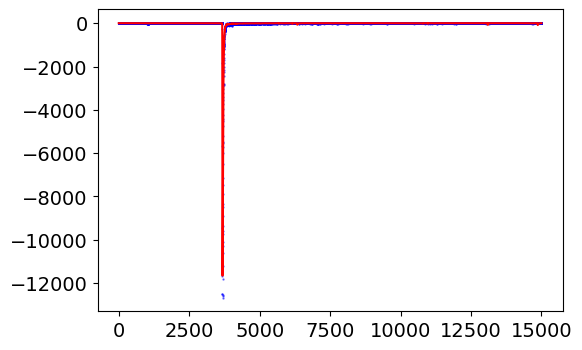

In [160]:
%%time
m = random.sample(m, 5)
for n in range(len(m)):    
    wavenum = XFEL_p_waveform_number_1[m][n]-1
#     print(wavenum, m[n])
    print(XFEL_p_t0pil_Had_1[m][n]*fs*2e-3,  XFEL_p_amppil_Had_1[m][n],   XFEL_p_chi2pil_Had_1[m][n]/1e7)
    print(XFEL_p_rundata_1[m][n].decode('utf-8'))
    if XFEL_p_rundata_1[m][n].decode('utf-8')[14:19] == 'XFEL0': 
        infolder ='../../../../../../../../media/s/SeagateHD/'+XFEL_p_rundata_1[m][n].decode('utf-8')[14:20]+'/'
        chunks = pd.read_csv(infolder+XFEL_p_rundata_1[m][n].decode('utf-8')+'.txt', skiprows=wavenum*15000, chunksize = 15000,  header = None)
    else: 
        infolder ='../../../../../../../../media/s/SeagateHD/'+XFEL_p_rundata_1[m][n].decode('utf-8')[14:25]+'/'
        chunks = pd.read_csv(infolder+XFEL_p_rundata_1[m][n].decode('utf-8')+'.txt', skiprows=wavenum*15000, chunksize = 15000,  header = None)

    trace_3 = chunks.get_chunk(15000).values.reshape( 15000, 1)
    trace_3 = trace_3.T-np.expand_dims(trace_3[100:1000,:].mean(axis=0), axis=0).T
    print (np.sum(trace_3/np.min(trace_3, axis =1), axis =1))
    print (integrate.trapz(y = trace_3, dx = 1)/np.min(trace_3, axis =1))
    print(trace_3.shape)
    plt.scatter(np.arange(15000), trace_3[0], label='Signal %s'%m[n], color='blue', marker = '.' , alpha=0.5, s =2)
    plt.plot(np.arange(15000), XFEL_p_amp_Had_1[m][n]*np.roll(TemplateHAD_p, round(XFEL_p_t0_Had_1[m][n]*(1/2e-9))), 
            label='Hadron fit ', color='red',linewidth ='1.5')#, linestyle='dotted')
    plt.plot(np.arange(15000), XFEL_p_amp_1[m][n]*np.roll(TemplateEM_p, round(XFEL_p_t0_1[m][n]*(1/2e-9))), 
            label='EM fit ', color='green',linewidth ='1.5')#, linestyle='dotted')
    plt.ylabel(r'Light output [ADC]',fontsize = 16)
    plt.xlabel(r'Time [$\mu$s]',fontsize = 16)
    plt.title('CsI pure - XFEL Beam ON',fontsize = 16)
    plt.tick_params(which='both', direction='in', right=True, top=True)
    plt.legend(loc = 'lower right', fontsize =16)
    plt.xlim(7.2/2e-3,7.6/2e-3)
    plt.grid(linestyle='dotted')
    plt.minorticks_on()
    plt.show()
#     if n ==0: template_array = trace_3
#     else: template_array = np.append(template_array,trace_3, axis=0)
    


In [103]:
# print(len(XFEL_p['t0_pileup_EM'][:]), len(XFEL_p_t0pil), len(XFEL_p_t0pil_1))
# plt.hist(XFEL_p['t0_pileup_EM'][:]*fs*2e-3, bins =50)
# plt.yscale('log')
# plt.title('CsI pure - Beam ON - before pre-selection')
# plt.xlabel('Pileup t0 [ms]')
# plt.ylabel('a.u.')
# plt.show()
# plt.hist(XFEL_p_t0pil*fs*2e-3, bins =50)
# plt.yscale('log')
# plt.title('CsI pure - Beam ON - after pre-selection')
# plt.xlabel('Pileup t0 [ms]')
# plt.ylabel('a.u.')
# plt.show()
# plt.hist(XFEL_p_t0pil_1*fs*2e-3, bins =50)
# plt.yscale('log')
# plt.title('CsI pure - Beam ON - after fine-tuning')
# plt.xlabel('Pileup t0 [ms]')
# plt.ylabel('a.u.')
# plt.show()